In [1]:
import pandas as pd
import numpy as np
import os
os.getcwd()

'/Users/praveen/MSDS/MachineLearning/KaggleChallenges/Challenge2/Data'

In [2]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import community.community_louvain as community_louvain

# -- Filepaths (assumes all CSVs live in your working dir) --
paths = {
    "all_cand_state": "all_candidates_state_bipartite_weighted_network.csv",
    "win_cand_state": "winning_candidates_state_bipartite_weighted_network.csv",
    "state_top100": "state_contributor_top100_contributors_network.csv",
    "fed_top100": "federal_contributor_top100_contributors_network.csv"
}

# -- Helper to load bipartite candidate↔state CSV into a NetworkX graph --
def load_bipartite(path):
    df = pd.read_csv(path, index_col=0)
    G = nx.Graph()
    # tag nodes by type
    G.add_nodes_from(df.index, bipartite="candidate")
    G.add_nodes_from(df.columns, bipartite="state")
    # add weighted edges
    for cand in df.index:
        for st, w in df.loc[cand].items():
            if pd.notna(w) and w > 0:
                G.add_edge(cand, st, weight=w)
    return G

# load both “all candidates” and “winning candidates” graphs
G_all = load_bipartite(paths["all_cand_state"])
G_win = load_bipartite(paths["win_cand_state"])

# project onto states to get state‐state co‐funding networks
states = [n for n,d in G_all.nodes(data=True) if d["bipartite"]=="state"]
P_states_all = bipartite.weighted_projected_graph(G_all, states)
P_states_win = bipartite.weighted_projected_graph(G_win, states)

# -- Helper to load contributor–contributor CSV into a graph --
def load_contrib_network(path):
    df = pd.read_csv(path, index_col=0)
    G = nx.Graph()
    G.add_nodes_from(df.index)
    for u in df.index:
        for v, w in df.loc[u].items():
            if u!=v and pd.notna(w) and w>0:
                G.add_edge(u, v, weight=w)
    return G

# load state‐level and federal‐level top100 co‐investment networks
G_state_contrib = load_contrib_network(paths["state_top100"])
G_fed_contrib   = load_contrib_network(paths["fed_top100"])

# -- Enrich a graph with centralities + Louvain communities --
def enrich_graph(G):
    H = G.to_undirected()                     # treat everything as undirected
    deg = dict(H.degree())                    # binary degree
    wdeg = dict(H.degree(weight="weight"))    # weighted degree
    pr = nx.pagerank(H, alpha=0.85, weight="weight", tol=1e-3)
    part = community_louvain.best_partition(H, weight="weight")
    nx.set_node_attributes(H, deg, "degree")
    nx.set_node_attributes(H, wdeg, "weighted_degree")
    nx.set_node_attributes(H, pr, "pagerank")
    nx.set_node_attributes(H, part, "louvain")
    return H

# apply enrichment
P_states_all     = enrich_graph(P_states_all)
P_states_win     = enrich_graph(P_states_win)
G_state_contrib  = enrich_graph(G_state_contrib)
G_fed_contrib    = enrich_graph(G_fed_contrib)

# export to GEXF for later inspection (optional)
nx.write_gexf(P_states_all,    "states_all_candidates_enriched.gexf")
nx.write_gexf(P_states_win,    "states_winning_candidates_enriched.gexf")
nx.write_gexf(G_state_contrib, "state_contrib_top100_enriched.gexf")
nx.write_gexf(G_fed_contrib,   "federal_contrib_top100_enriched.gexf")

print("✅ Network features extracted and GEXFs saved.")


✅ Network features extracted and GEXFs saved.


In [3]:
import pandas as pd
import networkx as nx
from IPython.display import display, Markdown

def summarize_network(path, display_name):
    # Load graph
    G = nx.read_gexf(path)
    
    # Extract node features into DataFrame
    data = []
    for n, attrs in G.nodes(data=True):
        data.append({
            "node": n,
            "degree": attrs.get("degree", 0),
            "weighted_degree": attrs.get("weighted_degree", 0),
            "pagerank": attrs.get("pagerank", 0.0),
            "community": attrs.get("louvain", -1)
        })
    df = pd.DataFrame(data).set_index("node")
    
    # Display header
    display(Markdown(f"## Network: {display_name}"))
    
    # Summary statistics
    display(Markdown("**Summary Statistics:**"))
    display(df[["degree", "weighted_degree", "pagerank"]].describe().T)
    
    # Top 10 by each metric
    display(Markdown("**Top 10 by Degree:**"))
    display(df.sort_values("degree", ascending=False).head(10)[["degree"]])
    
    display(Markdown("**Top 10 by Weighted Degree:**"))
    display(df.sort_values("weighted_degree", ascending=False).head(10)[["weighted_degree"]])
    
    display(Markdown("**Top 10 by PageRank:**"))
    display(df.sort_values("pagerank", ascending=False).head(10)[["pagerank"]])
    
    # Community sizes
    display(Markdown("**Community Sizes (Louvain):**"))
    comm_sizes = df["community"].value_counts().rename_axis("community").reset_index(name="size")
    display(comm_sizes)
    
    return df

# Paths to your enriched GEXF files
paths = {
    "All Candidates → State (states_all_candidates_enriched.gexf)": "states_all_candidates_enriched.gexf",
    "Winning Candidates → State (states_winning_candidates_enriched.gexf)": "states_winning_candidates_enriched.gexf",
    "State Top100 Contributors (state_contrib_top100_enriched.gexf)": "state_contrib_top100_enriched.gexf",
    "Federal Top100 Contributors (federal_contrib_top100_enriched.gexf)": "federal_contrib_top100_enriched.gexf"
}

# Run summaries
summaries = {}
for name, path in paths.items():
    summaries[name] = summarize_network(path, name)


## Network: All Candidates → State (states_all_candidates_enriched.gexf)

**Summary Statistics:**

,count,mean,std,min,25%,50%,75%,max
degree,65.0,36.000000,17.687390,0.00000,27.000000,42.000000,49.000000,58.000000
weighted_degree,65.0,905.723077,1260.281225,0.00000,61.000000,410.000000,1158.000000,4937.000000
pagerank,65.0,0.015385,0.018093,0.00237,0.003197,0.008602,0.019339,0.073553


**Top 10 by Degree:**

,degree
node,
NC,58
VA,58
TX,57
MA,54
DC,54
FL,54
CA,54
OH,53
MD,53


**Top 10 by Weighted Degree:**

,weighted_degree
node,
DC,4937
NC,4664
VA,4452
CA,3998
TX,3714
FL,3557
NJ,2937
NY,2539
MA,2070


**Top 10 by PageRank:**

,pagerank
node,
NC,0.073553
DC,0.071643
VA,0.066577
CA,0.058493
TX,0.056080
FL,0.052396
NJ,0.043469
NY,0.038538
MA,0.032080


**Community Sizes (Louvain):**

,community,size
0,1,26
1,4,19
2,2,18
3,0,1
4,3,1


## Network: Winning Candidates → State (states_winning_candidates_enriched.gexf)

**Summary Statistics:**

,count,mean,std,min,25%,50%,75%,max
degree,65.0,34.400000,17.605752,0.00000,21.000000,41.000000,48.0000,58.000000
weighted_degree,65.0,791.046154,1122.071472,0.00000,40.000000,328.000000,1002.0000,4310.000000
pagerank,65.0,0.015385,0.018475,0.00237,0.003168,0.008053,0.0196,0.077636


**Top 10 by Degree:**

,degree
node,
NC,58
VA,58
TX,57
FL,54
DC,54
CA,53
NY,53
IL,52
MA,52


**Top 10 by Weighted Degree:**

,weighted_degree
node,
NC,4310
DC,4274
VA,3968
CA,3412
TX,3374
FL,3312
NJ,2644
NY,2213
MA,1671


**Top 10 by PageRank:**

,pagerank
node,
NC,0.077636
DC,0.071092
VA,0.067917
TX,0.058282
CA,0.057200
FL,0.055735
NJ,0.044712
NY,0.038716
MA,0.029763


**Community Sizes (Louvain):**

,community,size
0,4,27
1,1,22
2,2,14
3,0,1
4,3,1


## Network: State Top100 Contributors (state_contrib_top100_enriched.gexf)

**Summary Statistics:**

,count,mean,std,min,25%,50%,75%,max
degree,200.0,1.295000e+01,1.381382e+01,0.000000,2.750000,8.500000e+00,2.000000e+01,7.100000e+01
weighted_degree,200.0,4.068311e+07,8.082838e+07,0.000000,141806.440000,3.915600e+06,4.593471e+07,4.427149e+08
pagerank,200.0,5.000000e-03,5.107606e-03,0.000906,0.000981,2.735749e-03,7.811751e-03,2.497040e-02


**Top 10 by Degree:**

,degree
node,
"TRUMP, DONALD J NEW YORK 10022 NY",71
CENTURYLINK RALEIGH 27601 NC,69
FULBRIGHT & JAWORSKI HOUSTON 77010 TX,61
"CATSIMATIDIS, JOHN A NEW YORK 10065 NY",61
LINBARGER GOGGAN BLAIR & SAMPSON AUSTIN 78760 TX,57
"KRAMER, ORIN S NEW YORK 10022 NY",51
"FORD, GERALD J DALLAS 75201 TX",46
CARPENTERS & JOINERS DISTRICT COUNCIL OF DC & NEW YORK NEW YORK 10014 NY,44
1199 SEIU UNITED HEALTH CARE WORKERS NEW YORK 10108 NY,42


**Top 10 by Weighted Degree:**

,weighted_degree
node,
NEW JERSEY STATE LABORERS MONROE TOWNSHIP 8831 NJ,4.427149e+08
ELECTRICAL WORKERS LOCAL 164 PARAMUS 7652 NJ,4.095803e+08
"CORZINE, JON S HOBOKEN 7030 NJ",3.761866e+08
1199 SEIU UNITED HEALTH CARE WORKERS NEW YORK 10108 NY,3.099182e+08
NEW JERSEY EDUCATION ASSOCIATION TRENTON 8607 NJ,3.066865e+08
FULBRIGHT & JAWORSKI HOUSTON 77010 TX,3.044352e+08
"CATSIMATIDIS, JOHN A NEW YORK 10065 NY",3.026449e+08
FUEL MERCHANTS ASSOCIATION OF NEW JERSEY SPRINGFIELD 7081 NJ,2.912483e+08
CENTURYLINK RALEIGH 27601 NC,2.821533e+08


**Top 10 by PageRank:**

,pagerank
node,
CENTURYLINK RALEIGH 27601 NC,0.024970
"CATSIMATIDIS, JOHN A NEW YORK 10065 NY",0.022108
FULBRIGHT & JAWORSKI HOUSTON 77010 TX,0.021589
NEW JERSEY STATE LABORERS MONROE TOWNSHIP 8831 NJ,0.021262
ELECTRICAL WORKERS LOCAL 164 PARAMUS 7652 NJ,0.018540
1199 SEIU UNITED HEALTH CARE WORKERS NEW YORK 10108 NY,0.018164
ANDREWS & KURTH HOUSTON 77002 TX,0.017694
LINBARGER GOGGAN BLAIR & SAMPSON AUSTIN 78760 TX,0.017310
NEW JERSEY EDUCATION ASSOCIATION TRENTON 8607 NJ,0.016644


**Community Sizes (Louvain):**

,community,size
0,2,28
1,7,27
2,1,25
3,15,19
4,8,18
5,19,11
6,11,9
7,31,8
8,5,8
9,0,6


## Network: Federal Top100 Contributors (federal_contrib_top100_enriched.gexf)

**Summary Statistics:**

,count,mean,std,min,25%,50%,75%,max
degree,200.0,1.235700e+02,5.183173e+01,0.000000,1.007500e+02,1.315000e+02,1.700000e+02,1.840000e+02
weighted_degree,200.0,3.160484e+09,3.467064e+09,0.000000,1.519084e+08,1.060610e+09,6.015995e+09,1.236248e+10
pagerank,200.0,5.000000e-03,4.484530e-03,0.000764,1.008004e-03,2.529323e-03,8.677065e-03,1.675703e-02


**Top 10 by Degree:**

,degree
node,
AMERICAN FAMILY LIFE ASSURANCE CO / AFLAC COLUMBUS 31999 GA,184
HONEYWELL INTERNATIONAL WASHINGTON 20001 DC,183
AMERICAN ASSOCIATION OF ORTHOPAEDIC SURGEONS WASHINGTON 20002 DC,182
UPS ATLANTA 30328 GA,182
NATIONAL ASSOCIATION OF REALTORS CHICAGO 60611 IL,180
CREDIT UNION NATIONAL ASSOCIATION / CUNA WASHINGTON 20004 DC,180
NATIONAL STONE SAND & GRAVEL ASSOCIATION ALEXANDRIA 22314 VA,180
COMCAST PHILADELPHIA 19103 PA,180
NATIONAL AUTOMOBILE DEALERS ASSOCIATION MCLEAN 22102 VA,179


**Top 10 by Weighted Degree:**

,weighted_degree
node,
HONEYWELL INTERNATIONAL WASHINGTON 20001 DC,1.236248e+10
CREDIT UNION NATIONAL ASSOCIATION / CUNA WASHINGTON 20004 DC,1.204402e+10
VERIZON COMMUNICATIONS WASHINGTON 20005 DC,1.091501e+10
UPS ATLANTA 30328 GA,1.053798e+10
AMERICAN FAMILY LIFE ASSURANCE CO / AFLAC COLUMBUS 31999 GA,1.051659e+10
NATIONAL ASSOCIATION OF REALTORS CHICAGO 60611 IL,1.041528e+10
COMCAST PHILADELPHIA 19103 PA,1.013614e+10
BOEING CO ARLINGTON 22209 VA,1.009566e+10
AMERICAN HOSPITAL ASSOCIATION WASHINGTON 20004 DC,9.936155e+09


**Top 10 by PageRank:**

,pagerank
node,
HONEYWELL INTERNATIONAL WASHINGTON 20001 DC,0.016757
CREDIT UNION NATIONAL ASSOCIATION / CUNA WASHINGTON 20004 DC,0.016461
VERIZON COMMUNICATIONS WASHINGTON 20005 DC,0.015190
AMERICAN FAMILY LIFE ASSURANCE CO / AFLAC COLUMBUS 31999 GA,0.014872
UPS ATLANTA 30328 GA,0.014521
NATIONAL ASSOCIATION OF REALTORS CHICAGO 60611 IL,0.014227
COMCAST PHILADELPHIA 19103 PA,0.014121
BOEING CO ARLINGTON 22209 VA,0.013935
NATIONAL ASSOCIATION OF HOME BUILDERS WASHINGTON 20005 DC,0.013911


**Community Sizes (Louvain):**

,community,size
0,2,103
1,6,70
2,4,23
3,1,1
4,0,1
5,5,1
6,3,1


### All Candidates → State – Top 10 by **Degree**

,degree
state,
NC,2497.0
VA,1860.0
TX,1763.0
FL,1567.0
CA,1372.0
DC,1254.0
NJ,940.0
WA,903.0
CO,857.0


### All Candidates → State – Top 10 by **Weighted Degree**

,weighted_degree
state,
NC,18573.078576
VA,13933.944615
TX,12175.465441
FL,11513.034834
CA,10139.846326
DC,9551.731980
NJ,6563.947046
WA,6148.550304
CO,5495.954762


### All Candidates → State – Top 10 by **Pagerank**

,pagerank
state,
NC,0.079499
VA,0.052947
TX,0.052394
FL,0.048412
CA,0.035610
WA,0.034116
MT,0.029193
CO,0.029062
MA,0.024342


### Winning Candidates → State – Top 10 by **Degree**

,degree
state,
NC,2170.0
VA,1550.0
TX,1462.0
FL,1235.0
DC,1021.0
CA,988.0
NJ,817.0
CO,602.0
WA,576.0


### Winning Candidates → State – Top 10 by **Weighted Degree**

,weighted_degree
state,
NC,16347.785888
VA,11821.835615
TX,10162.537247
FL,9376.363761
DC,7887.668186
CA,7518.469886
NJ,5735.388196
WA,4099.780632
CO,3980.214972


### Winning Candidates → State – Top 10 by **Pagerank**

,pagerank
state,
NC,0.096061
VA,0.059950
TX,0.058596
FL,0.048637
CA,0.030918
WA,0.028074
CO,0.026341
NJ,0.026071
SD,0.025983


### State Top100 Contributors – Top 10 by **Degree**

,degree
contributor,
"TRUMP, DONALD J NEW YORK 10022 NY",71.0
CENTURYLINK RALEIGH 27601 NC,69.0
FULBRIGHT & JAWORSKI HOUSTON 77010 TX,61.0
"CATSIMATIDIS, JOHN A NEW YORK 10065 NY",61.0
LINBARGER GOGGAN BLAIR & SAMPSON AUSTIN 78760 TX,57.0
"KRAMER, ORIN S NEW YORK 10022 NY",51.0
"FORD, GERALD J DALLAS 75201 TX",46.0
CARPENTERS & JOINERS DISTRICT COUNCIL OF DC & NEW YORK NEW YORK 10014 NY,44.0
1199 SEIU UNITED HEALTH CARE WORKERS NEW YORK 10108 NY,42.0


### State Top100 Contributors – Top 10 by **Weighted Degree**

,weighted_degree
contributor,
NEW JERSEY STATE LABORERS MONROE TOWNSHIP 8831 NJ,4.427149e+08
ELECTRICAL WORKERS LOCAL 164 PARAMUS 7652 NJ,4.095803e+08
"CORZINE, JON S HOBOKEN 7030 NJ",3.761866e+08
1199 SEIU UNITED HEALTH CARE WORKERS NEW YORK 10108 NY,3.099182e+08
NEW JERSEY EDUCATION ASSOCIATION TRENTON 8607 NJ,3.066865e+08
FULBRIGHT & JAWORSKI HOUSTON 77010 TX,3.044352e+08
"CATSIMATIDIS, JOHN A NEW YORK 10065 NY",3.026449e+08
FUEL MERCHANTS ASSOCIATION OF NEW JERSEY SPRINGFIELD 7081 NJ,2.912483e+08
CENTURYLINK RALEIGH 27601 NC,2.821533e+08


### State Top100 Contributors – Top 10 by **Pagerank**

,pagerank
contributor,
CENTURYLINK RALEIGH 27601 NC,0.024970
"CATSIMATIDIS, JOHN A NEW YORK 10065 NY",0.022108
FULBRIGHT & JAWORSKI HOUSTON 77010 TX,0.021589
NEW JERSEY STATE LABORERS MONROE TOWNSHIP 8831 NJ,0.021262
ELECTRICAL WORKERS LOCAL 164 PARAMUS 7652 NJ,0.018540
1199 SEIU UNITED HEALTH CARE WORKERS NEW YORK 10108 NY,0.018164
ANDREWS & KURTH HOUSTON 77002 TX,0.017694
LINBARGER GOGGAN BLAIR & SAMPSON AUSTIN 78760 TX,0.017310
NEW JERSEY EDUCATION ASSOCIATION TRENTON 8607 NJ,0.016644


### Federal Top100 Contributors – Top 10 by **Degree**

,degree
contributor,
AMERICAN FAMILY LIFE ASSURANCE CO / AFLAC COLUMBUS 31999 GA,184.0
HONEYWELL INTERNATIONAL WASHINGTON 20001 DC,183.0
AMERICAN ASSOCIATION OF ORTHOPAEDIC SURGEONS WASHINGTON 20002 DC,182.0
UPS ATLANTA 30328 GA,182.0
NATIONAL ASSOCIATION OF REALTORS CHICAGO 60611 IL,180.0
CREDIT UNION NATIONAL ASSOCIATION / CUNA WASHINGTON 20004 DC,180.0
NATIONAL STONE SAND & GRAVEL ASSOCIATION ALEXANDRIA 22314 VA,180.0
COMCAST PHILADELPHIA 19103 PA,180.0
NATIONAL AUTOMOBILE DEALERS ASSOCIATION MCLEAN 22102 VA,179.0


### Federal Top100 Contributors – Top 10 by **Weighted Degree**

,weighted_degree
contributor,
HONEYWELL INTERNATIONAL WASHINGTON 20001 DC,1.236248e+10
CREDIT UNION NATIONAL ASSOCIATION / CUNA WASHINGTON 20004 DC,1.204402e+10
VERIZON COMMUNICATIONS WASHINGTON 20005 DC,1.091501e+10
UPS ATLANTA 30328 GA,1.053798e+10
AMERICAN FAMILY LIFE ASSURANCE CO / AFLAC COLUMBUS 31999 GA,1.051659e+10
NATIONAL ASSOCIATION OF REALTORS CHICAGO 60611 IL,1.041528e+10
COMCAST PHILADELPHIA 19103 PA,1.013614e+10
BOEING CO ARLINGTON 22209 VA,1.009566e+10
AMERICAN HOSPITAL ASSOCIATION WASHINGTON 20004 DC,9.936155e+09


### Federal Top100 Contributors – Top 10 by **Pagerank**

,pagerank
contributor,
HONEYWELL INTERNATIONAL WASHINGTON 20001 DC,0.016757
CREDIT UNION NATIONAL ASSOCIATION / CUNA WASHINGTON 20004 DC,0.016461
VERIZON COMMUNICATIONS WASHINGTON 20005 DC,0.015190
AMERICAN FAMILY LIFE ASSURANCE CO / AFLAC COLUMBUS 31999 GA,0.014872
UPS ATLANTA 30328 GA,0.014521
NATIONAL ASSOCIATION OF REALTORS CHICAGO 60611 IL,0.014227
COMCAST PHILADELPHIA 19103 PA,0.014121
BOEING CO ARLINGTON 22209 VA,0.013935
NATIONAL ASSOCIATION OF HOME BUILDERS WASHINGTON 20005 DC,0.013911


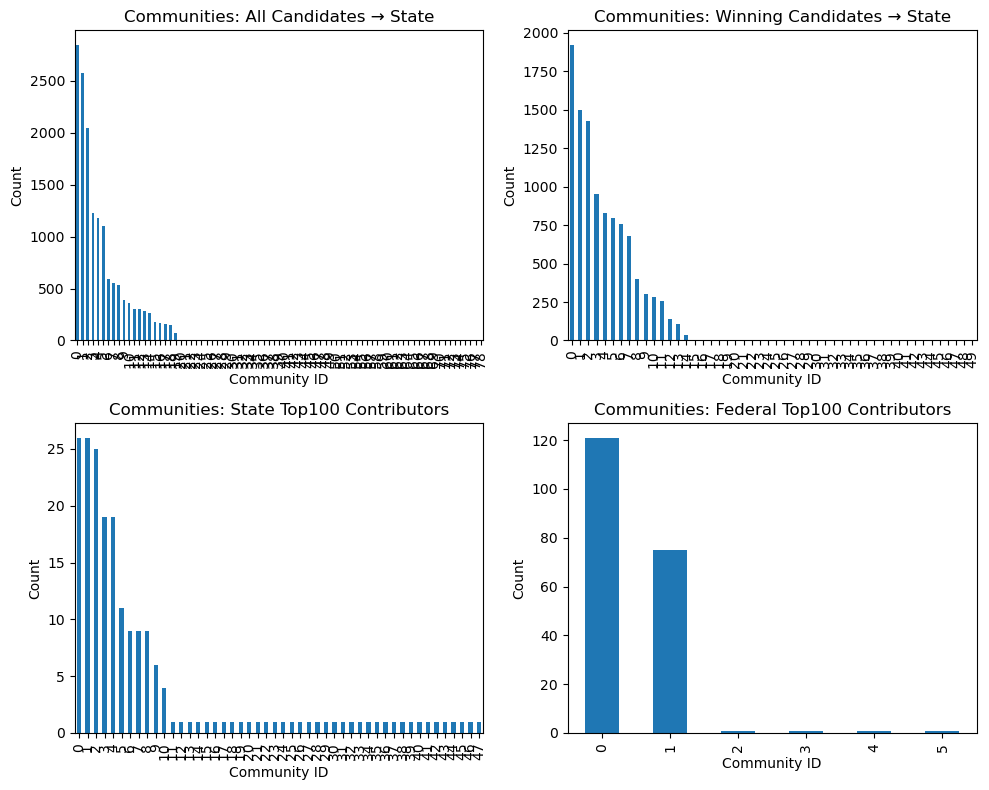

<Figure size 800x400 with 0 Axes>

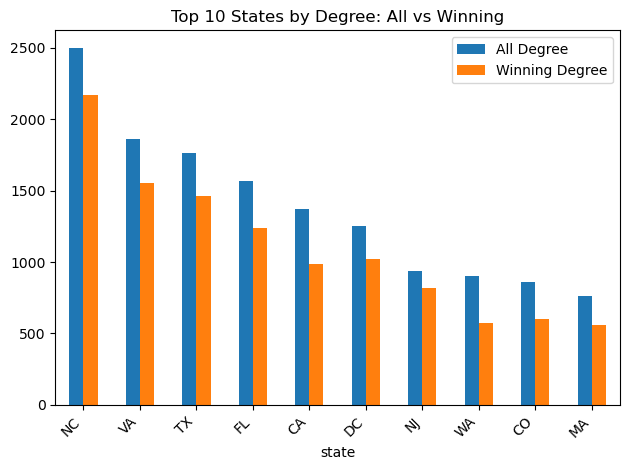

<Figure size 800x400 with 0 Axes>

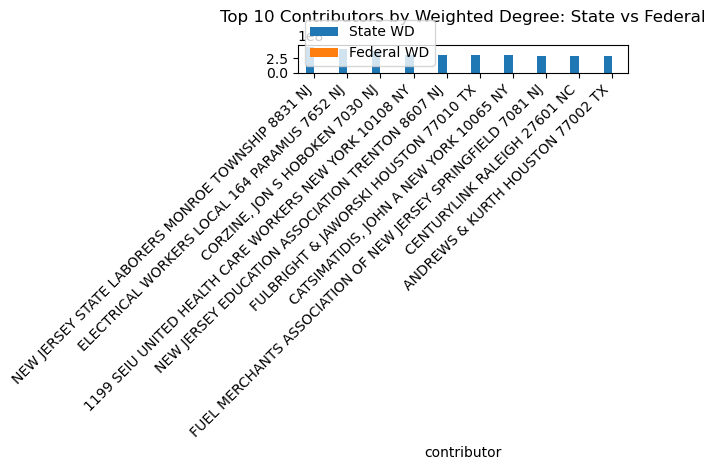

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from networkx.algorithms.community import greedy_modularity_communities

# 1) Build & enrich each of the four networks, then save out an "_enriched.gexf"
def build_enrich(from_csv, node_type, gexf_out):
    df = pd.read_csv(from_csv, index_col=0)
    G = nx.Graph()
    G.add_nodes_from(df.index)

    # edges: any positive weight
    for u in df.index:
        for v, w in df.loc[u].items():
            if pd.notna(w) and w>0 and u!=v:
                G.add_edge(u, v, weight=float(w))

    # compute metrics
    deg  = dict(G.degree())
    wdeg = dict(G.degree(weight='weight'))
    pr   = nx.pagerank(G, alpha=0.85, weight='weight', tol=1e-3)
    comm = greedy_modularity_communities(G, weight='weight')
    part = {n: cid for cid, com in enumerate(comm) for n in com}

    # set attributes & write to disk
    for n in G:
        G.nodes[n].update({
            'degree':         deg.get(n, 0),
            'weighted_degree':wdeg.get(n, 0),
            'pagerank':       pr.get(n, 0.0),
            'community':      part.get(n, -1),
        })
    nx.write_gexf(G, gexf_out)
    return gexf_out

# run enrichment for all 4
files = [
    ("all_candidates_state_bipartite_weighted_network.csv",
     "state",  "states_all_candidates_enriched.gexf"),
    ("winning_candidates_state_bipartite_weighted_network.csv",
     "state",  "states_winning_candidates_enriched.gexf"),
    ("state_contributor_top100_contributors_network.csv",
     "contributor", "state_contrib_top100_enriched.gexf"),
    ("federal_contributor_top100_contributors_network.csv",
     "contributor", "federal_contrib_top100_enriched.gexf"),
]
for csv, ntype, out in files:
    build_enrich(csv, ntype, out)

# 2) A helper to read any enriched GEXF into a DataFrame
def gexf_to_df(path, index_name):
    G = nx.read_gexf(path)
    rows=[]
    for n, a in G.nodes(data=True):
        rows.append({
            index_name:          n,
            'degree':            float(a['degree']),
            'weighted_degree':   float(a['weighted_degree']),
            'pagerank':          float(a['pagerank']),
            'community':         int(a['community'])
        })
    return pd.DataFrame(rows).set_index(index_name)

# load them back in
df_all_states    = gexf_to_df("states_all_candidates_enriched.gexf",    "state")
df_win_states    = gexf_to_df("states_winning_candidates_enriched.gexf", "state")
df_state_contrib = gexf_to_df("state_contrib_top100_enriched.gexf",      "contributor")
df_fed_contrib   = gexf_to_df("federal_contrib_top100_enriched.gexf",    "contributor")

networks = [
    ("All Candidates → State",    df_all_states),
    ("Winning Candidates → State",df_win_states),
    ("State Top100 Contributors",  df_state_contrib),
    ("Federal Top100 Contributors",df_fed_contrib),
]

# 3) Top‑10 tables
metrics = ["degree","weighted_degree","pagerank"]
for title, df in networks:
    for m in metrics:
        display(Markdown(f"### {title} – Top 10 by **{m.replace('_',' ').title()}**"))
        display(df[[m]].sort_values(m, ascending=False).head(10))

# 4) Community sizes (2×2)
plt.figure(figsize=(10,8))
for i,(title,df) in enumerate(networks,1):
    plt.subplot(2,2,i)
    df['community'].value_counts().sort_index().plot.bar()
    plt.title(f"Communities: {title}")
    plt.xlabel("Community ID"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# 5) Side‑by‑side comparisons
# 5a) States degree
comp_states = pd.DataFrame({
    "All Degree":     df_all_states['degree'],
    "Winning Degree": df_win_states['degree']
}).sort_values("All Degree",ascending=False).head(10)
plt.figure(figsize=(8,4))
comp_states.plot.bar()
plt.title("Top 10 States by Degree: All vs Winning")
plt.xticks(rotation=45,ha='right'); plt.tight_layout(); plt.show()

# 5b) Contributors weighted_degree
comp_contrib = pd.DataFrame({
    "State WD":   df_state_contrib['weighted_degree'],
    "Federal WD": df_fed_contrib['weighted_degree']
}).sort_values("State WD",ascending=False).head(10)
plt.figure(figsize=(8,4))
comp_contrib.plot.bar()
plt.title("Top 10 Contributors by Weighted Degree: State vs Federal")
plt.xticks(rotation=45,ha='right'); plt.tight_layout(); plt.show()


In [5]:
comp_states

,All Degree,Winning Degree
state,,
NC,2497.0,2170.0
VA,1860.0,1550.0
TX,1763.0,1462.0
FL,1567.0,1235.0
CA,1372.0,988.0
DC,1254.0,1021.0
NJ,940.0,817.0
WA,903.0,576.0
CO,857.0,602.0


In [6]:
comp_contrib

,State WD,Federal WD
contributor,,
NEW JERSEY STATE LABORERS MONROE TOWNSHIP 8831 NJ,4.427149e+08,NaN
ELECTRICAL WORKERS LOCAL 164 PARAMUS 7652 NJ,4.095803e+08,NaN
"CORZINE, JON S HOBOKEN 7030 NJ",3.761866e+08,NaN
1199 SEIU UNITED HEALTH CARE WORKERS NEW YORK 10108 NY,3.099182e+08,NaN
NEW JERSEY EDUCATION ASSOCIATION TRENTON 8607 NJ,3.066865e+08,NaN
FULBRIGHT & JAWORSKI HOUSTON 77010 TX,3.044352e+08,NaN
"CATSIMATIDIS, JOHN A NEW YORK 10065 NY",3.026449e+08,NaN
FUEL MERCHANTS ASSOCIATION OF NEW JERSEY SPRINGFIELD 7081 NJ,2.912483e+08,NaN
CENTURYLINK RALEIGH 27601 NC,2.821533e+08,NaN


In [7]:
import pandas as pd
import networkx as nx

# Helper to load enriched GEXF and return DataFrame
def load_enriched_gexf(path, index_name, prefix):
    G = nx.read_gexf(path)
    rows = []
    for node, attrs in G.nodes(data=True):
        row = {index_name: node}
        # pick and prefix each attribute
        row[f"{prefix}_deg"] = float(attrs.get('degree', 0))
        row[f"{prefix}_wdeg"] = float(attrs.get('weighted_degree', 0))
        row[f"{prefix}_pr"] = float(attrs.get('pagerank', 0))
        row[f"{prefix}_comm"] = int(attrs.get('community', attrs.get('louvain', -1)))
        rows.append(row)
    return pd.DataFrame(rows).set_index(index_name)

# 1) Read training data
train = pd.read_csv("training_data.csv", index_col=0)

# 2) Load contributor-level features
df_state_contrib = load_enriched_gexf(
    "state_contrib_top100_enriched.gexf", index_name="contributor", prefix="contrib_state")
df_fed_contrib = load_enriched_gexf(
    "federal_contrib_top100_enriched.gexf", index_name="contributor", prefix="contrib_fed")

# 3) Load state-level features
df_all_states = load_enriched_gexf(
    "states_all_candidates_enriched.gexf", index_name="state", prefix="state_all")
df_win_states = load_enriched_gexf(
    "states_winning_candidates_enriched.gexf", index_name="state", prefix="state_win")

# 4) Merge contributor-level features on the index
train = train.merge(df_state_contrib, left_index=True, right_index=True, how="left")
train = train.merge(df_fed_contrib,   left_index=True, right_index=True, how="left")

# 5) Merge state-level features on the 'state' column
train = train.merge(df_all_states,    left_on="state", right_index=True, how="left")
train = train.merge(df_win_states,    left_on="state", right_index=True, how="left")

# 6) Fill any missing values
train.fillna(0, inplace=True)

# 7) Inspect the resulting columns
print("Final training columns:")
train.columns.tolist()


/var/folders/h5/yfvk0l4921v0kg94n8qt42wc0000gn/T/ipykernel_36477/315582905.py:19: DtypeWarning: Columns (31,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("training_data.csv", index_col=0)


Final training columns:


['city',
 'zip_code',
 'specific_sector',
 'state',
 'contributor_type',
 'winner_ratio',
 'candidacy_count',
 'candidacy_democratic_count',
 'candidacy_republican_count',
 'contribution_count',
 'contribution_democratic_count',
 'contribution_republican_count',
 'politician_challenger_count',
 'politician_count',
 'politician_democratic_count',
 'politician_incumbency_count',
 'politician_open_pos_count',
 'politician_republican_count',
 'contribution_democratic_sum_2010_usd',
 'contribution_republican_sum_2010_usd',
 'contribution_sum_2010_usd',
 'governor_contributions_sum_2010_usd',
 'house_and_assembly_contributions_sum_2010_usd',
 'senate_contributions_sum_2010_usd',
 'us_house_contributions_sum_2010_usd',
 'us_senate_contributions_sum_2010_usd',
 'candidacy_democratic_ratio',
 'candidacy_republican_ratio',
 'contribution_democratic_count_ratio',
 'contribution_republican_count_ratio',
 'governor_contribution_ratio',
 'house_and_assembly_contribution_ratio',
 'politician_challeng

Top 20 Correlated Features                                        correlation_with_winner_ratio
politician_incumbency_ratio                                 0.510403
politician_challenger_ratio                                -0.335755
politician_open_pos_ratio                                  -0.257573
politician_challenger_count                                -0.121556
politician_incumbency_count                                 0.112190
house_and_assembly_contribution_ratio                       0.086319
politician_count                                            0.060199
politician_republican_count                                 0.058934
candidacy_count                                             0.057132
candidacy_republican_count                                  0.055234
candidacy_democratic_count                                  0.045846
politician_democratic_count                                 0.044282
state_all_wdeg                                             -0.042225
state_a

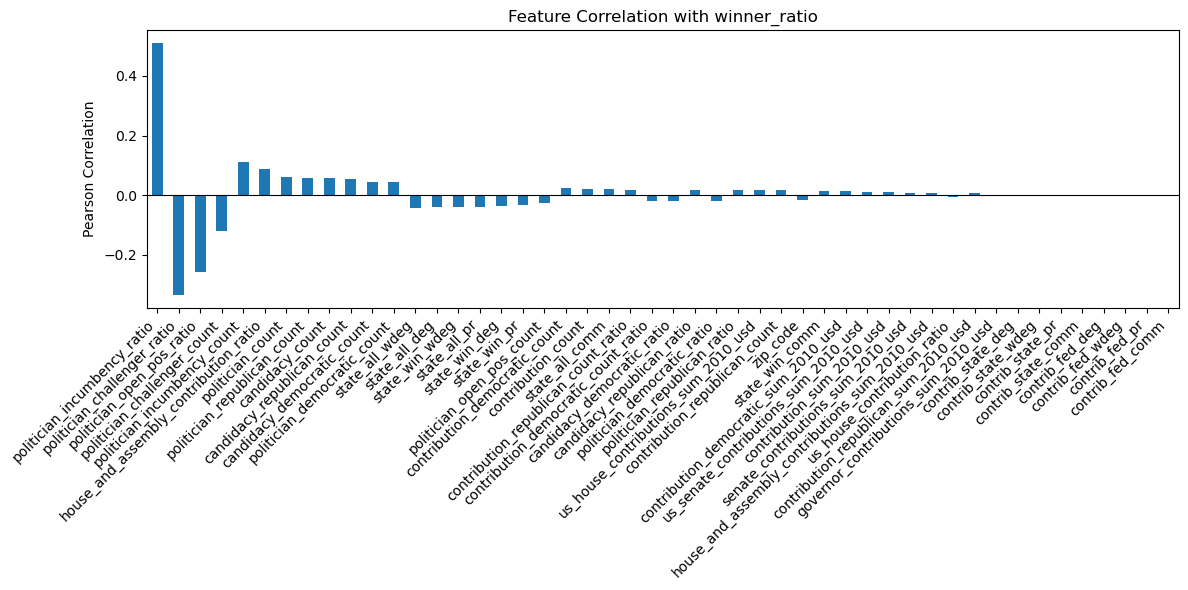

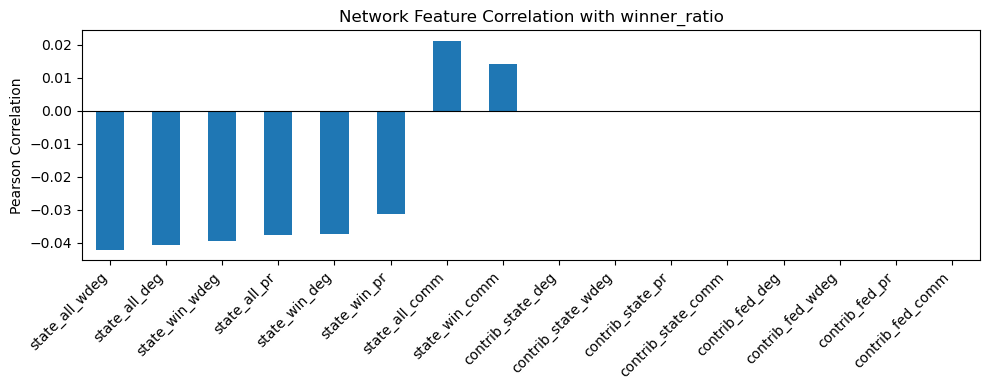

In [8]:
# 2) Select only numerical columns
# from ace_tools import display_dataframe_to_user

num_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# 3) Compute Pearson correlation with 'winner_ratio'
corr_with_target = train[num_cols].corr()['winner_ratio'].drop('winner_ratio')

# 4) Sort by absolute correlation descending
corr_sorted = corr_with_target.reindex(corr_with_target.abs().sort_values(ascending=False).index)

# 5) Display the top 20 most correlated features
top20 = corr_sorted.head(20).to_frame(name='correlation_with_winner_ratio')
print("Top 20 Correlated Features", top20)

# 6) Bar plot of all correlations
plt.figure(figsize=(12, 6))
corr_sorted.plot.bar()
plt.title("Feature Correlation with winner_ratio")
plt.ylabel("Pearson Correlation")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7) If you want to focus on network features only:
network_feats = [c for c in corr_sorted.index if c.startswith(("contrib_state_", "contrib_fed_", "state_all_", "state_win_"))]
plt.figure(figsize=(10, 4))
corr_sorted[network_feats].plot.bar()
plt.title("Network Feature Correlation with winner_ratio")
plt.ylabel("Pearson Correlation")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
train.to_csv("./train_data_new.csv")

In [10]:
train.to_csv("./train_data_new.csv")

In [12]:
test = pd.read_csv("./test_data.csv")

In [13]:

# 4) Merge contributor-level features on the index
test = test.merge(df_state_contrib, left_index=True, right_index=True, how="left")
test = test.merge(df_fed_contrib,   left_index=True, right_index=True, how="left")

# 5) Merge state-level features on the 'state' column
test = test.merge(df_all_states,    left_on="state", right_index=True, how="left")
test = test.merge(df_win_states,    left_on="state", right_index=True, how="left")

# 6) Fill any missing values
test.fillna(0, inplace=True)
test.to_csv("./test_data_new.csv")


In [3]:


# 5) Prepare X / y
y = train["winner_ratio"]
X = train.drop("winner_ratio", axis=1)

X_tr, X_val, y_tr, y_val = train_test_split(X, y,
                                            test_size=0.2,
                                            random_state=42)

# 6) Train & evaluate
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_tr, y_tr)

y_pred = model.predict(X_val)
mse    = mean_squared_error(y_val, y_pred)
print(f"✅ Validation MSE = {mse:.5f}")

# 7) Final test set is enriched, ready for .predict()


/var/folders/h5/yfvk0l4921v0kg94n8qt42wc0000gn/T/ipykernel_25958/1571068906.py:7: DtypeWarning: Columns (31,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("training_data.csv", index_col=0)
